# Создание и обучение нейросети в Keras. Задача регрессии.

## Boston Housing
Для решения задачи регрессии возьмём датасет Boston Housing. В нём в качестве признаков используются описательные и количественные (см. ниже) данные о недвижимости, а в качестве целевой переменной - цена в тысячах долларов.

Список признаков:

- **crim**: Per capita crime rate by town.
- **zn**: Proportion of residential land zoned for lots over 25,000 sq.ft.
- **indus**: Proportion of non-retail business acres per town.
- **chas**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
- **nox**: Nitrogen oxides concentration (parts per 10 million).
- **rm**: Average number of rooms per dwelling.
- **age**: Proportion of owner-occupied units built prior to 1940.
- **dis**: Weighted mean of distances to five Boston employment centres.
- **rad**: Index of accessibility to radial highways.
- **tax**: Full-value property-tax rate per \$10,000.
- **ptratio**: Pupil-teacher ratio by town.
- **black**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
- **lstat**: Lower status of the population (percent).

In [15]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

print(f'Признаки: {x_train[0, :]}')
print(f'\nОтвет: {y_train[0]}')

Признаки: [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]

Ответ: 15.2


Очевидно, что данные нужно нормализовать. Для этого воспользуемся классом `MinMaxScaler` из библиотеки `sklearn.preprocessing`. Он позволяет линейно масштабировать численные признаки в интервал от 0 до 1. Его использование аналогично `LabelEncoder`.

In [24]:
from sklearn.preprocessing import MinMaxScaler
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

features_encoder, answers_encoder = MinMaxScaler(), MinMaxScaler()
features_encoder.fit(x_train), answers_encoder.fit(y_train.reshape(-1, 1));

x_train_scaled = features_encoder.transform(x_train)
y_train_scaled = answers_encoder.transform(y_train.reshape(-1, 1)).flatten()
x_test_scaled = features_encoder.transform(x_test)
y_test_scaled = answers_encoder.transform(y_test.reshape(-1, 1)).flatten()

print(f'Признаки: {x_train_scaled[0, :]}')
print(f'\nОтвет: {y_train_scaled[0]}')

Признаки: [0.01378163 0.         0.28152493 0.         0.31481481 0.49980635
 0.91452111 0.29719123 0.13043478 0.22753346 0.89361702 1.
 0.46881898]

Ответ: 0.22666666666666668


In [125]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.datasets import mnist
from keras.optimizers import SGD, Adam
from keras.losses import logcosh
from keras.metrics import MSE, MAE

from sklearn.preprocessing import MinMaxScaler
from keras.datasets import boston_housing

# Подгружаем датасет
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

# И начинаем собирать модель:
model = Sequential()

# Хватит и одного слоя: 
model.add(Dense(units=32,  
                input_dim=x_train.shape[1],
                kernel_initializer='he_normal',
                use_bias=True))
model.add(Activation('relu'))  # Не забываем про активационную функцию
model.add(Dropout(0.2))  # И Dropout

# Выходной слой состоит из единственного нейрона.
# Функцию потерь для лучше выбрать линейной, потому, что, в общем случае, масштаб признаков может оказаться другим.
# В таком случае ReLU отсечёт всё, что ниже минимума train, потому, что он масштабируется в 0.
model.add(Dense(1))  
model.add(Activation('linear'))

# Выбираем оптимизатор, функцию потерь и метрики
optimizer = Adam(lr=0.005, amsgrad=True, decay=0.01)
loss = logcosh
metrics = [MSE, MAE]  # Введём сразу две метрики

# После чего собираем модель
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Готовим (масштабируем) данные
features_encoder, answers_encoder = MinMaxScaler(), MinMaxScaler()
features_encoder.fit(x_train), answers_encoder.fit(y_train.reshape(-1, 1));

x_train_scaled = features_encoder.transform(x_train)
y_train_scaled = answers_encoder.transform(y_train.reshape(-1, 1)).flatten()
x_test_scaled = features_encoder.transform(x_test)
y_test_scaled = answers_encoder.transform(y_test.reshape(-1, 1)).flatten()

# Всё, модель можно обучать:
model.fit(x_train_scaled, y_train_scaled, 
          epochs=50, 
          batch_size=8, 
          validation_data=(x_test_scaled, y_test_scaled), 
          verbose=False);

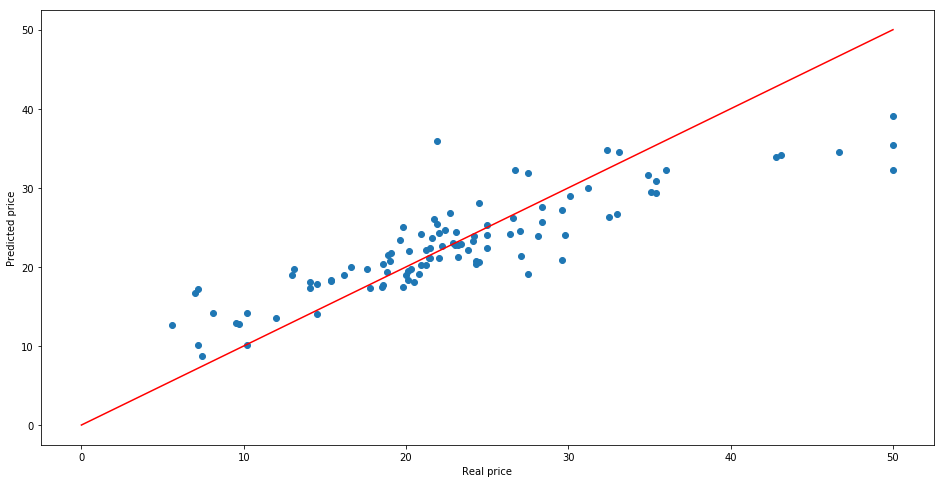

In [129]:
from sklearn.preprocessing import MinMaxScaler
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

features_encoder, answers_encoder = MinMaxScaler(), MinMaxScaler()
features_encoder.fit(x_train), answers_encoder.fit(y_train.reshape(-1, 1));

x_train_scaled = features_encoder.transform(x_train)
y_train_scaled = answers_encoder.transform(y_train.reshape(-1, 1)).flatten()
x_test_scaled = features_encoder.transform(x_test)

plot = 'test'
if plot == 'train':
    x, y = x_train_scaled, y_train_scaled
    pred = model.predict(x) 
else:
    x, y = x_test_scaled, y_test
    pred = model.predict(x_test_scaled)
    pred = answers_encoder.inverse_transform(pred.reshape(-1, 1)).flatten()
    
plt.figure(figsize=(16, 8))
plt.scatter(y, pred)
plt.plot([0, np.max(y)], [0, np.max(y)], c='r')
plt.xlabel('Real price')
plt.ylabel('Predicted price');